In [1]:
# Data reading 
import pandas as pd 

# Array math 
import numpy as np

# Random number generation
import random

# Dates 
import datetime

# Ploting 
import matplotlib.pyplot as plt 
import seaborn as sns

# Deep learning
from tensorflow import keras
from NNmodel import NNMultiCountryModel

In [2]:
# Downloading data 
dl_data = False

if dl_data:
    !python3 dataDownload.py

In [3]:
# Creating tidy data
!python3 createTidyData.py

In [4]:
def create_X_Y_generalized(ts: np.array, n_features: int, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [5]:
# Hyper parameters for analysis
start_date_analysis = datetime.datetime(2020, 4, 1).date()

# Features in models 
features_models = ['is_hospitalized', 'is_covid']

# Wrangling LT data

In [6]:
d = pd.read_csv('data/tidy_data_LT.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the data since the second wave
d = d[d['day']>= start_date_analysis]

# Leaving only the time series 
dLT = d.copy()

# Saving the days list 
daysLT = d.day

# Calculating the rolling mean for Lithuania data 
dLTmean = dLT.rolling(window=7).mean()

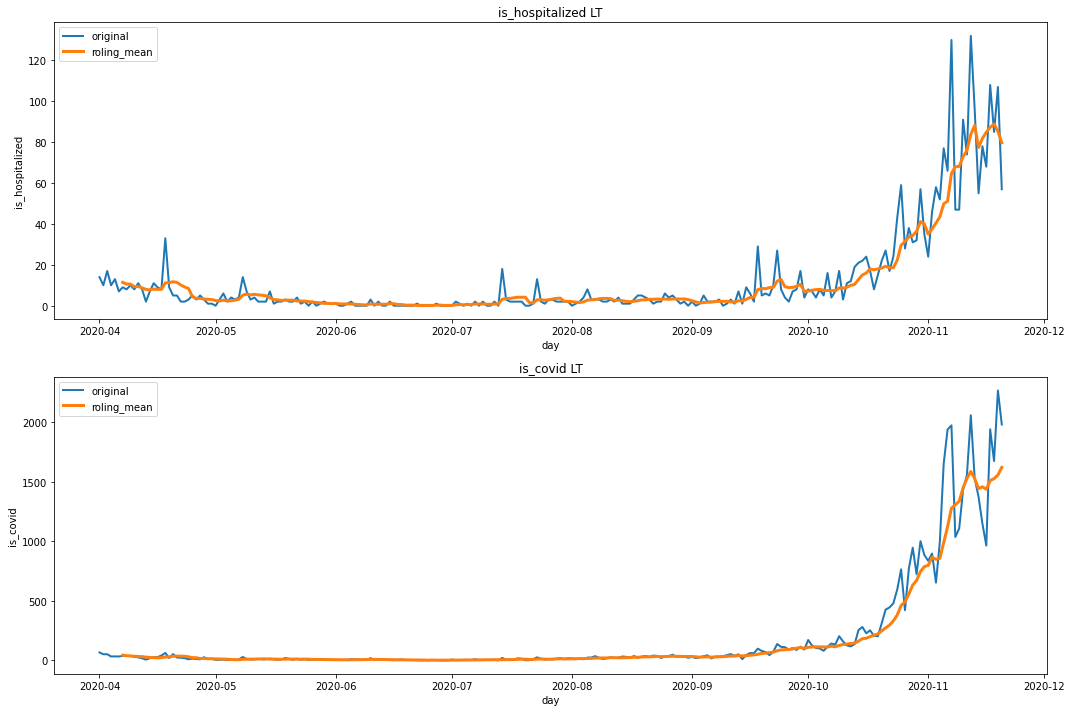

In [7]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = features_models

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=d['day'], y=dLT[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=d['day'], y=dLTmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} LT')
        
plt.tight_layout()

# Wrangling Estonia data

In [8]:
d = pd.read_csv('data/tidy_data_EST.csv')

# Sorting by date 
d['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in d['day']]
d.sort_values('day', inplace=True)

# Leaving only the data since the second wave
d = d[d['day']>= start_date_analysis]

# Leaving only the time series 
dEST = d.copy()

# Saving the days list 
daysEST = d.day

# Calculating the rolling mean for Lithuania data 
dESTmean = dEST.rolling(window=7).mean()

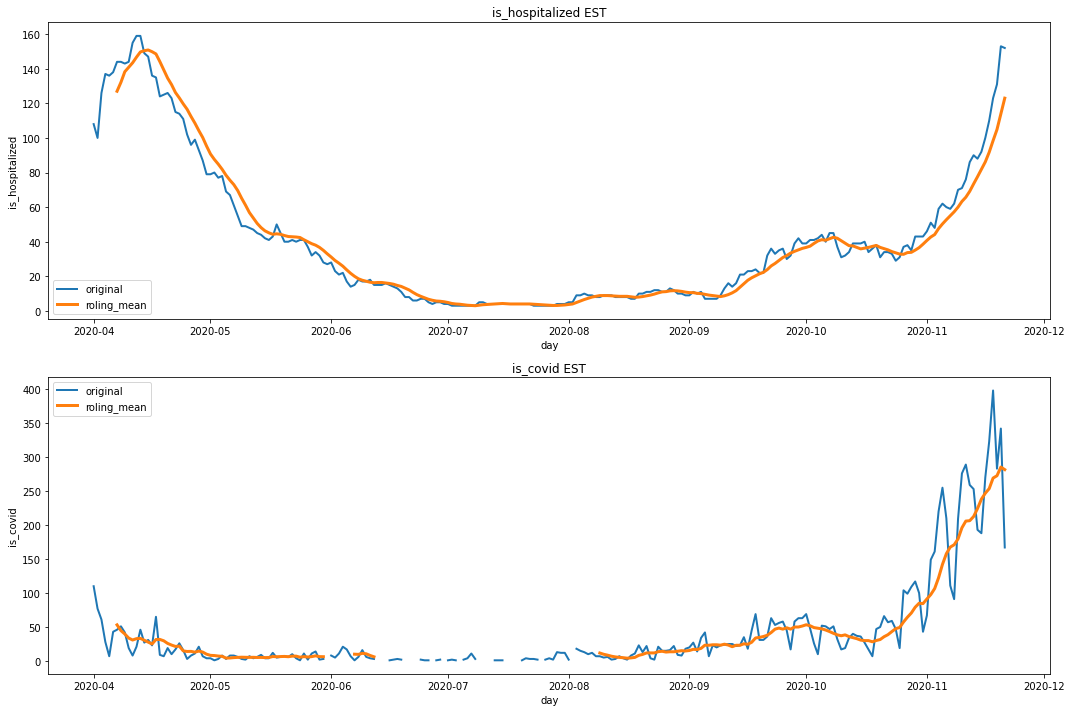

In [9]:
# Ploting some states
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = features_models

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=daysEST, y=dEST[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=daysEST, y=dESTmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} EST')
        
plt.tight_layout()

# Wrangling US data 

In [10]:
dUS = pd.read_csv('data/tidy_data_US.csv')

# Sorting by date 
dUS['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in dUS['day']]
dUS.sort_values('day', inplace=True)

# Leaving only the data since the second wave
dUS = dUS[dUS['day']>= start_date_analysis]

# Droping the date column
daysUS = dUS['day']
dUS = dUS.copy()

# Getting the rolling mean 
dUSmean = dUS.rolling(window=7).mean()

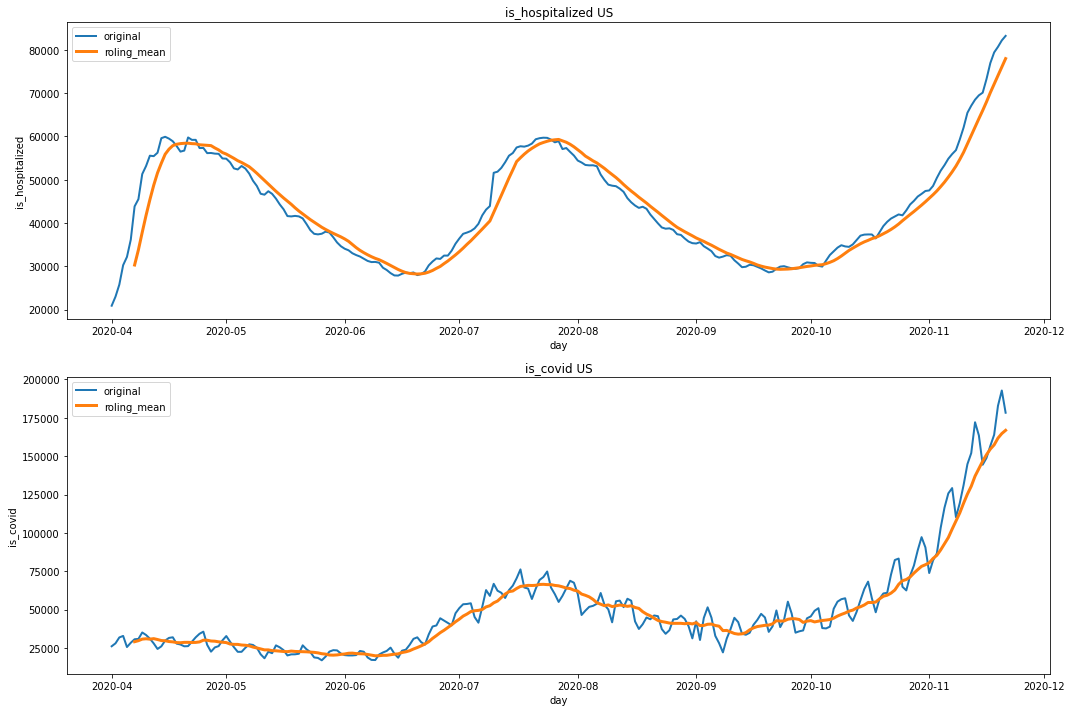

In [11]:
# Ploting some states
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

features = features_models

for i, feature in enumerate(features):
    sns.lineplot(ax=axes[i], x=daysUS, y=dUS[feature], linewidth=2, label='original')
    sns.lineplot(ax=axes[i], x=daysUS, y=dUSmean[feature], linewidth=3, label='roling_mean')
    axes[i].set_title(f'{feature} US')
        
plt.tight_layout()

In [12]:
# Getting the common dates between datasets
days_max = min([max(daysUS), max(daysLT), max(daysEST)])
days_min = max([min(daysUS), min(daysLT), min(daysEST)])

# Subsetting all the datasets 
dLT = dLT[(dLT['day']<=days_max) & (dLT['day'] >= days_min)]
dEST = dEST[(dEST['day']<=days_max) & (dEST['day'] >= days_min)]
dUS = dUS[(dUS['day']<=days_max) & (dUS['day'] >= days_min)]

# Reseting the indexes
dLT.reset_index(inplace=True, drop=True)
dEST.reset_index(inplace=True, drop=True)
dUS.reset_index(inplace=True, drop=True)

# Leaving only the features
dLT = dLT[features_models]
dUS = dUS[features_models]
dEST = dEST[features_models]

# Calculating percentage changes in all the datasets

In [13]:
# US data
dUS_pct = dUS.pct_change()
dUS_pct = dUS_pct.replace([np.inf, -np.inf], np.nan)
dUS_pct.fillna(0, inplace=True)    
    
# Dataset for Lithuania
dLT_pct = dLT.pct_change()
dLT_pct = dLT_pct.replace([np.inf, -np.inf], np.nan)
dLT_pct.fillna(0, inplace=True)

# Dataset for Estonia
dEST_pct = dEST.pct_change()
dEST_pct = dEST_pct.replace([np.inf, -np.inf], np.nan)
dEST_pct.fillna(0, inplace=True)

# Visualizing the data that will be modeled

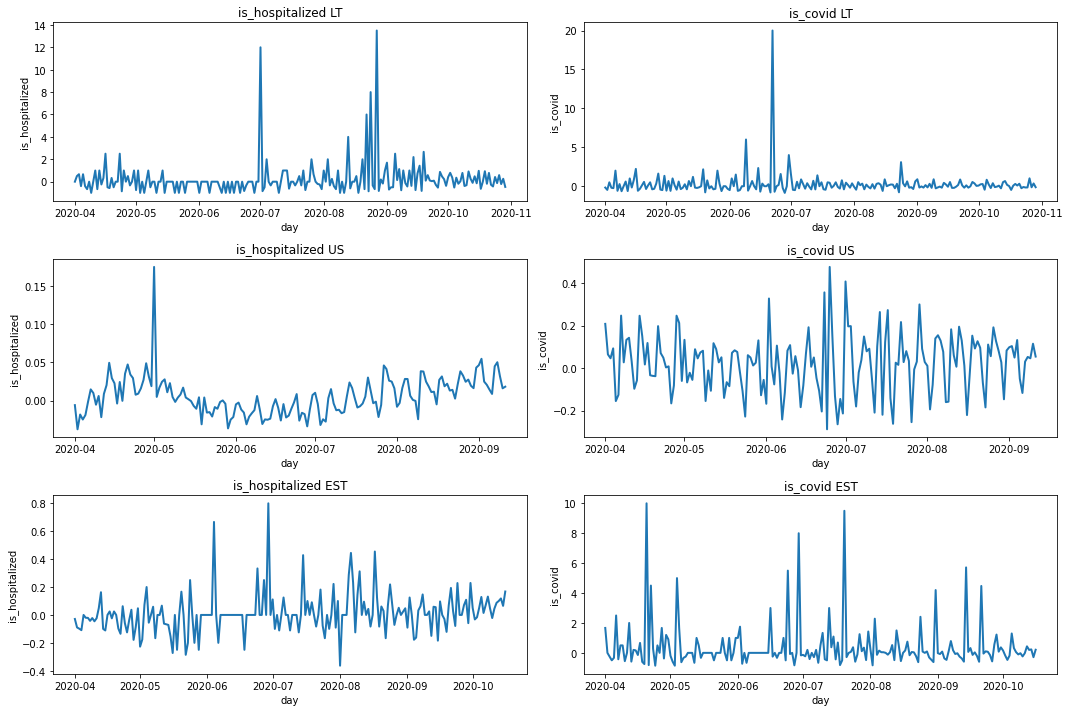

In [14]:
fig, axes = plt.subplots(
    nrows=3, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features_models):
    sns.lineplot(ax=axes[0, i], x=daysLT, y=dLT_pct[feature], linewidth=2)
    axes[0, i].set_title(f'{feature} LT')

for i, feature in enumerate(features_models):
    sns.lineplot(ax=axes[1, i], x=daysUS, y=dUS_pct[feature], linewidth=2)
    axes[1, i].set_title(f'{feature} US')    

    
for i, feature in enumerate(features_models):
    sns.lineplot(ax=axes[2, i], x=daysEST, y=dEST_pct[feature], linewidth=2)
    axes[2, i].set_title(f'{feature} EST')
    
plt.tight_layout()

# Creating the dataframes for training 

In [15]:
# Setting the hyper parameters 
# Defining the lag 
n_lag = 14

# Defining the steps ahead to forecast 
n_ahead = 5

# Number of features used in the model 
n_ft = len(features_models)

In [16]:
Xus, Yus = create_X_Y_generalized(dUS_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)
Xes, Yes = create_X_Y_generalized(dEST_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)
Xlt, Ylt = create_X_Y_generalized(dLT_pct.values, n_features=n_ft, lag=n_lag, n_ahead=n_ahead)

X = [Xus, Xes, Xlt]
Y = [Yus, Yes, Ylt]

#X = np.concatenate([Xes, Xlt]) 
#Y = np.concatenate([Yes, Ylt])

In [17]:
# Defining the number of last n_ahead obs to keep in the validation set
n_val = 1

# All indexes 
ind = list(range(len(X[0])))

# Getting the indexes for training 
train_idx = ind[:-n_val]

# Getting the indexes for validation 
val_idx = list(set(ind) - set(train_idx))

# Extracting train and validation matrices for deep learning training
XtrainUS, YtrainUS = X[0][train_idx], Y[0][train_idx]
XtrainES, YtrainES = X[1][train_idx], Y[1][train_idx]
XtrainLT, YtrainLT = X[2][train_idx], Y[2][train_idx]

XvalUS, YvalUS = X[0][val_idx], Y[0][val_idx]
XvalES, YvalES = X[1][val_idx], Y[1][val_idx]
XvalLT, YvalLT = X[2][val_idx], Y[2][val_idx]

Xtrain, Ytrain = [XtrainUS, XtrainES, XtrainLT], [YtrainUS, YtrainES, YtrainLT]
Xval, Yval = [XvalUS, XvalES, XvalLT], [YvalUS, YvalES, YvalLT]

#print(f"Shape of the training feature matrix (series): {Xtrain.shape}")
#print(f"Shape of the validation feature matrix (series): {Xval.shape}")
#print(f"Shape of the target matrix: {Ytrain.shape}")
#print(f"Shape of the validation target matrix: {Yval.shape}")

In [18]:
# Creating the model object for validation 
modelVal = NNMultiCountryModel(
    X=Xtrain, 
    Y=Ytrain,
    Xval=Xval,
    Yval=Yval,
    n_lag=n_lag, 
    n_ft=n_ft,
    n_outputs=n_ahead
)

In [19]:
print(f'Number of epochs: {modelVal.epochs}')
print(f'Number of neurons in LSMT layer {modelVal.n_layer}')
print(f'Learning rate: {modelVal.lr}')

Number of epochs: 200
Number of neurons in LSMT layer 60
Learning rate: 0.0001


In [20]:
modelVal.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 2)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 14, 2)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 14, 2)]      0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 14, 2)        0           input_1[0][0]                    
_______________________________________________________________________________________

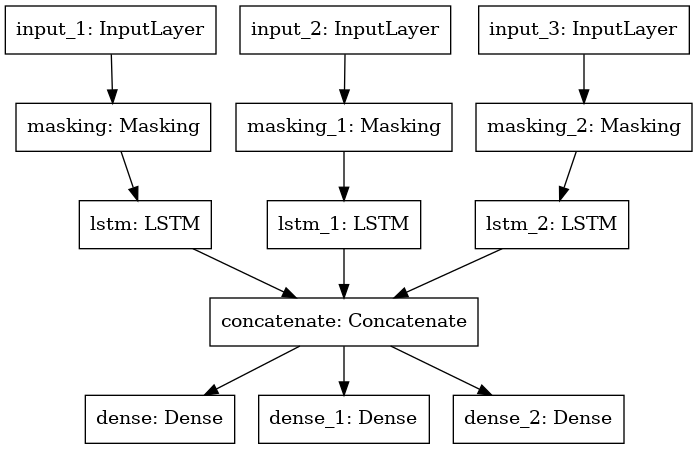

In [21]:
keras.utils.plot_model(modelVal.model)

In [22]:
history = modelVal.train()

Epoch 1/200
14/14 [==============================] - 1s 48ms/step - loss: 0.8790 - dense_loss: 0.0430 - dense_1_loss: 0.1083 - dense_2_loss: 0.7277 - val_loss: 0.4407 - val_dense_loss: 0.0442 - val_dense_1_loss: 0.0902 - val_dense_2_loss: 0.3063
Epoch 2/200
14/14 [==============================] - 0s 11ms/step - loss: 0.8677 - dense_loss: 0.0391 - dense_1_loss: 0.1036 - dense_2_loss: 0.7250 - val_loss: 0.4426 - val_dense_loss: 0.0430 - val_dense_1_loss: 0.0884 - val_dense_2_loss: 0.3112
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 0.8602 - dense_loss: 0.0371 - dense_1_loss: 0.1002 - dense_2_loss: 0.7229 - val_loss: 0.4439 - val_dense_loss: 0.0420 - val_dense_1_loss: 0.0862 - val_dense_2_loss: 0.3157
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 0.8543 - dense_loss: 0.0358 - dense_1_loss: 0.0974 - dense_2_loss: 0.7211 - val_loss: 0.4445 - val_dense_loss: 0.0412 - val_dense_1_loss: 0.0839 - val_dense_2_loss: 0.3194
Epoch 5/200
14/1

14/14 [==============================] - 0s 11ms/step - loss: 0.8170 - dense_loss: 0.0181 - dense_1_loss: 0.0844 - dense_2_loss: 0.7144 - val_loss: 0.4196 - val_dense_loss: 0.0212 - val_dense_1_loss: 0.0718 - val_dense_2_loss: 0.3266
Epoch 35/200
14/14 [==============================] - 0s 10ms/step - loss: 0.8165 - dense_loss: 0.0179 - dense_1_loss: 0.0843 - dense_2_loss: 0.7144 - val_loss: 0.4189 - val_dense_loss: 0.0207 - val_dense_1_loss: 0.0715 - val_dense_2_loss: 0.3266
Epoch 36/200
14/14 [==============================] - 0s 13ms/step - loss: 0.8160 - dense_loss: 0.0176 - dense_1_loss: 0.0841 - dense_2_loss: 0.7143 - val_loss: 0.4179 - val_dense_loss: 0.0203 - val_dense_1_loss: 0.0711 - val_dense_2_loss: 0.3265
Epoch 37/200
14/14 [==============================] - 0s 13ms/step - loss: 0.8156 - dense_loss: 0.0174 - dense_1_loss: 0.0840 - dense_2_loss: 0.7142 - val_loss: 0.4172 - val_dense_loss: 0.0199 - val_dense_1_loss: 0.0708 - val_dense_2_loss: 0.3265
Epoch 38/200
14/14 [=====

14/14 [==============================] - 0s 13ms/step - loss: 0.8072 - dense_loss: 0.0128 - dense_1_loss: 0.0816 - dense_2_loss: 0.7127 - val_loss: 0.4000 - val_dense_loss: 0.0136 - val_dense_1_loss: 0.0606 - val_dense_2_loss: 0.3258
Epoch 68/200
14/14 [==============================] - 0s 12ms/step - loss: 0.8070 - dense_loss: 0.0127 - dense_1_loss: 0.0815 - dense_2_loss: 0.7127 - val_loss: 0.3998 - val_dense_loss: 0.0140 - val_dense_1_loss: 0.0599 - val_dense_2_loss: 0.3259
Epoch 69/200
14/14 [==============================] - 0s 11ms/step - loss: 0.8068 - dense_loss: 0.0127 - dense_1_loss: 0.0815 - dense_2_loss: 0.7127 - val_loss: 0.3992 - val_dense_loss: 0.0137 - val_dense_1_loss: 0.0596 - val_dense_2_loss: 0.3259
Epoch 70/200
14/14 [==============================] - 0s 12ms/step - loss: 0.8066 - dense_loss: 0.0125 - dense_1_loss: 0.0814 - dense_2_loss: 0.7126 - val_loss: 0.3991 - val_dense_loss: 0.0141 - val_dense_1_loss: 0.0592 - val_dense_2_loss: 0.3258
Epoch 71/200
14/14 [=====

14/14 [==============================] - 0s 12ms/step - loss: 0.8023 - dense_loss: 0.0108 - dense_1_loss: 0.0800 - dense_2_loss: 0.7115 - val_loss: 0.3877 - val_dense_loss: 0.0125 - val_dense_1_loss: 0.0488 - val_dense_2_loss: 0.3264
Epoch 101/200
14/14 [==============================] - 0s 12ms/step - loss: 0.8021 - dense_loss: 0.0108 - dense_1_loss: 0.0799 - dense_2_loss: 0.7114 - val_loss: 0.3874 - val_dense_loss: 0.0128 - val_dense_1_loss: 0.0484 - val_dense_2_loss: 0.3262
Epoch 102/200
14/14 [==============================] - 0s 12ms/step - loss: 0.8021 - dense_loss: 0.0107 - dense_1_loss: 0.0799 - dense_2_loss: 0.7115 - val_loss: 0.3868 - val_dense_loss: 0.0123 - val_dense_1_loss: 0.0480 - val_dense_2_loss: 0.3265
Epoch 103/200
14/14 [==============================] - 0s 11ms/step - loss: 0.8019 - dense_loss: 0.0107 - dense_1_loss: 0.0799 - dense_2_loss: 0.7114 - val_loss: 0.3873 - val_dense_loss: 0.0128 - val_dense_1_loss: 0.0480 - val_dense_2_loss: 0.3265
Epoch 104/200
14/14 [=

14/14 [==============================] - 0s 11ms/step - loss: 0.7994 - dense_loss: 0.0100 - dense_1_loss: 0.0790 - dense_2_loss: 0.7104 - val_loss: 0.3785 - val_dense_loss: 0.0114 - val_dense_1_loss: 0.0408 - val_dense_2_loss: 0.3262
Epoch 134/200
14/14 [==============================] - 0s 12ms/step - loss: 0.7996 - dense_loss: 0.0100 - dense_1_loss: 0.0791 - dense_2_loss: 0.7105 - val_loss: 0.3772 - val_dense_loss: 0.0103 - val_dense_1_loss: 0.0417 - val_dense_2_loss: 0.3252
Epoch 135/200
14/14 [==============================] - 0s 12ms/step - loss: 0.7993 - dense_loss: 0.0100 - dense_1_loss: 0.0789 - dense_2_loss: 0.7104 - val_loss: 0.3779 - val_dense_loss: 0.0111 - val_dense_1_loss: 0.0410 - val_dense_2_loss: 0.3258
Epoch 136/200
14/14 [==============================] - 0s 11ms/step - loss: 0.7994 - dense_loss: 0.0100 - dense_1_loss: 0.0790 - dense_2_loss: 0.7104 - val_loss: 0.3781 - val_dense_loss: 0.0111 - val_dense_1_loss: 0.0411 - val_dense_2_loss: 0.3259
Epoch 137/200
14/14 [=

14/14 [==============================] - 0s 12ms/step - loss: 0.7974 - dense_loss: 0.0096 - dense_1_loss: 0.0784 - dense_2_loss: 0.7094 - val_loss: 0.3740 - val_dense_loss: 0.0101 - val_dense_1_loss: 0.0377 - val_dense_2_loss: 0.3262
Epoch 167/200
14/14 [==============================] - 0s 11ms/step - loss: 0.7972 - dense_loss: 0.0095 - dense_1_loss: 0.0784 - dense_2_loss: 0.7093 - val_loss: 0.3739 - val_dense_loss: 0.0097 - val_dense_1_loss: 0.0382 - val_dense_2_loss: 0.3260
Epoch 168/200
14/14 [==============================] - 0s 12ms/step - loss: 0.7971 - dense_loss: 0.0095 - dense_1_loss: 0.0783 - dense_2_loss: 0.7093 - val_loss: 0.3745 - val_dense_loss: 0.0106 - val_dense_1_loss: 0.0375 - val_dense_2_loss: 0.3265
Epoch 169/200
14/14 [==============================] - 0s 12ms/step - loss: 0.7972 - dense_loss: 0.0095 - dense_1_loss: 0.0784 - dense_2_loss: 0.7093 - val_loss: 0.3735 - val_dense_loss: 0.0099 - val_dense_1_loss: 0.0376 - val_dense_2_loss: 0.3260
Epoch 170/200
14/14 [=

14/14 [==============================] - 0s 12ms/step - loss: 0.7954 - dense_loss: 0.0091 - dense_1_loss: 0.0778 - dense_2_loss: 0.7085 - val_loss: 0.3726 - val_dense_loss: 0.0101 - val_dense_1_loss: 0.0348 - val_dense_2_loss: 0.3276
Epoch 200/200
14/14 [==============================] - 0s 11ms/step - loss: 0.7955 - dense_loss: 0.0093 - dense_1_loss: 0.0778 - dense_2_loss: 0.7084 - val_loss: 0.3727 - val_dense_loss: 0.0099 - val_dense_1_loss: 0.0348 - val_dense_2_loss: 0.3280


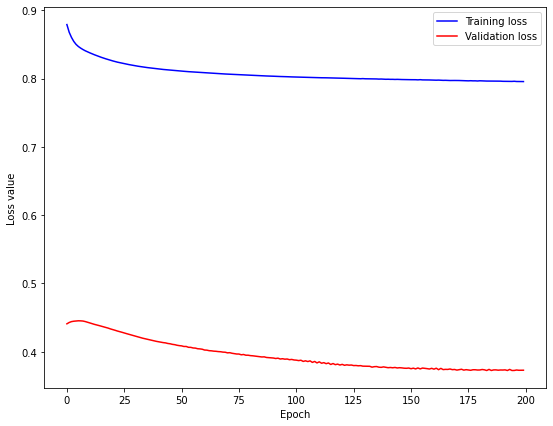

In [23]:
mse = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, mse, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()